In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def DR_cumulative_roas( scale, baseline ):
    ## function that simulates a DR channel's cumulative ROAS trajectory
    ## log function
    return lambda x: ( np.log( x ) * scale + baseline )

def create_channel( channel_roas_function, scale=None, baseline=None ):
    if scale is None:
        scale = np.random.uniform( 0.125, 0.4 )
    if baseline is None:
        baseline = np.random.normal( .04, .02 )
    cumulative_ROAS = channel_roas_function( scale, baseline )
    revenue_matrix = \
        np.array( 
            [ i * [ 0 ] + [ cumulative_ROAS( z ) for z in list( range( 1, periods + 1 - i, 1 ) ) ] \
             for i in range( periods ) ] 
        )
    daily_ad_spend = 2_500
    revenue_matrix *= daily_ad_spend
    revenue_total = revenue_matrix.sum( axis=0 )
    this_channel = {
        'scale': scale,
        'baseline': baseline,
        'cumulative_ROAS': cumulative_ROAS,
        'daily_ad_spend': daily_ad_spend,
        'revenue_matrix': revenue_matrix,
        'revenue_total': revenue_total
    }
    return this_channel

def graph_ax( ax, roas_values, periods, title, color='blue' ):
    ## plot the cumulative monetization curve
    ax.plot( range(1, periods + 1), \
        roas_values, 
        linewidth=4, color=color 
    )
    ax.grid( alpha=0.3 )
    ax.set_facecolor( "white" )
    fig.patch.set_facecolor( "white" )
    ax.yaxis.set_major_formatter( mtick.PercentFormatter( decimals=2 ) )
    ax.set_xlim( 0, periods + 1 )
    ax.set_ylim( 0, 120 )
    ## annotate day 5 ROAS
    y_value = roas_values[ 4 ]
    ax.annotate( f"{y_value:.2f}%", 
        xy=( 5, y_value * 1.1), 
        xytext=( 5, y_value * 1.1 ),
        fontsize=10,
        ha='center',
        color=color,
        bbox=dict( facecolor='whitesmoke', edgecolor='none', alpha=0.8 )
    )
    ## annotate day 30 ROAS
    y_value = roas_values[ -1 ]
    ax.annotate( f"{y_value:.2f}%", 
        xy=( 30, y_value * .8 ), 
        xytext=( 30, y_value * .8 ),
        fontsize=10,
        ha='center',
        color=color,
        bbox=dict( facecolor='whitesmoke', edgecolor='none', alpha=0.8 )
    )
    ax.set_title( title )

periods = 30
colors = [ 'dodgerblue', 'darkslategray', 'crimson', 'seagreen', 'midnightblue', 'goldenrod', 'firebrick' ]
channels = []

## define the DR channels
for i in range( 5 ):
    this_channel = create_channel( DR_cumulative_roas )
    channels.append( this_channel )

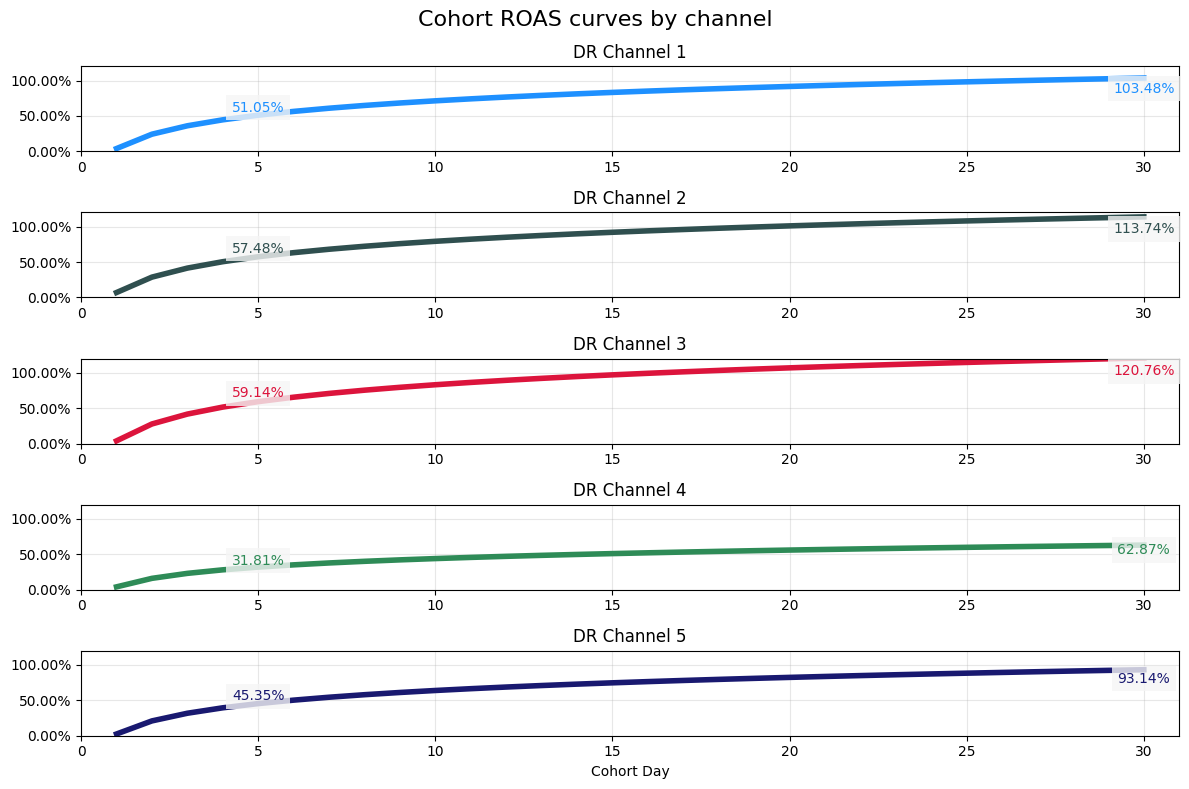

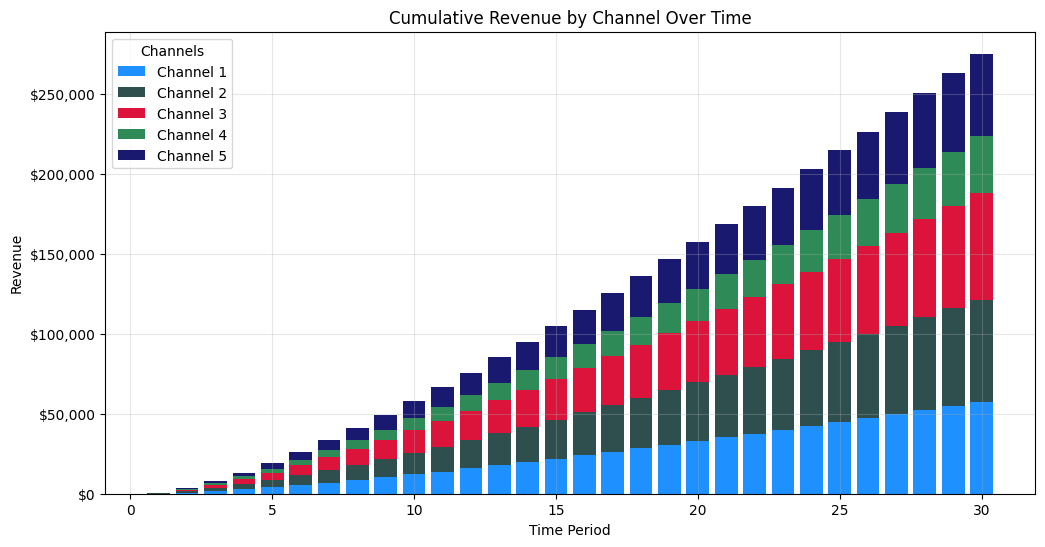

In [2]:
## plot the channel-level cumulative ROAS curves
fig, axes = plt.subplots( len( channels ), 1, figsize=( 12, 8 ) )
axes = axes.ravel()

for i, c in enumerate( channels ):
    roas_values = [ c[ 'cumulative_ROAS' ]( z ) * 100 for z in range( 1, periods + 1 ) ]
    graph_ax( axes[ i ], roas_values, periods, f"DR Channel {i+1}", color=colors[ i ] )

plt.xlabel( "Cohort Day" )

plt.suptitle( "Cohort ROAS curves by channel", fontsize=16 )
plt.tight_layout()
plt.show()

## plot the revenue totals
revenue_totals = np.array( [channel[ 'revenue_total' ] for channel in channels ] )

fig, ax = plt.subplots( figsize=( 12, 6 ) )
x = np.arange( 1, periods + 1 )

bottom = np.zeros( periods )
for i in range( len( channels ) ):
    ax.bar( x, revenue_totals[ i ], color=colors[ i ], bottom=bottom, label=f'Channel {i+1}' )
    bottom += revenue_totals[ i ]

ax.set_xlabel( 'Time Period' )
ax.set_ylabel( 'Revenue' )
ax.set_title( 'Cumulative Revenue by Channel Over Time' )
ax.legend( title="Channels" )
plt.grid( alpha=0.3 )

ax.yaxis.set_major_formatter( mtick.StrMethodFormatter( '${x:,.0f}' ) )

plt.show()

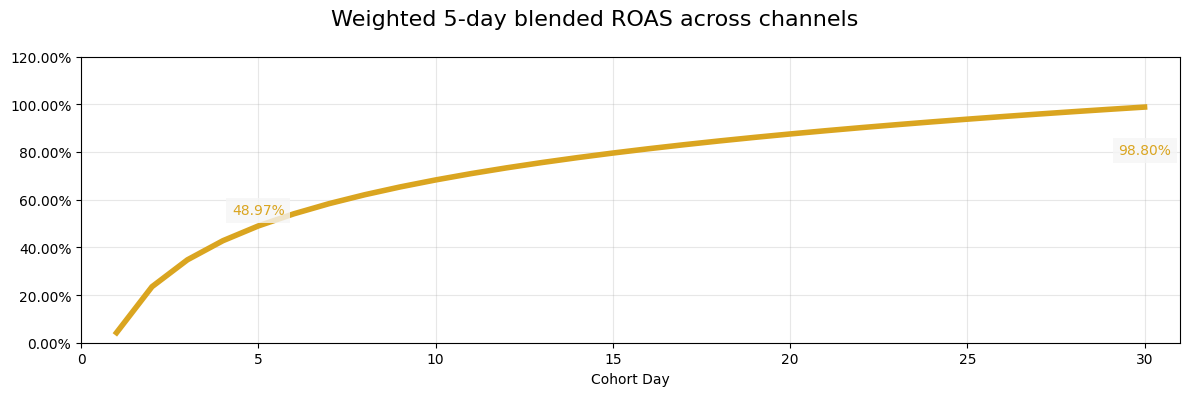

In [3]:
def get_total_ad_spend( channels ):
    return sum( [ c[ 'daily_ad_spend' ] for c in channels ] )

def get_blended_ROAS( channels, periods ):
    total_ad_spend = get_total_ad_spend( channels )
    blended_roas = np.stack( [ [ c[ 'cumulative_ROAS' ]( x ) * ( c[ 'daily_ad_spend' ] / total_ad_spend ) for x in range( 1, periods + 1 ) ] for c in channels ], axis=0 )
    blended_roas = blended_roas.sum( axis=0 ) * 100
    return blended_roas

## total blended DR ROAS
blended_roas = get_blended_ROAS( channels, periods )

fig, ax = plt.subplots( figsize=( 12, 4 ) )

graph_ax( ax, blended_roas, periods, "", color=colors[ -2 ] )

plt.xlabel( "Cohort Day" )

plt.suptitle( "Weighted 5-day blended ROAS across channels", fontsize=16 )
plt.tight_layout()
plt.show()

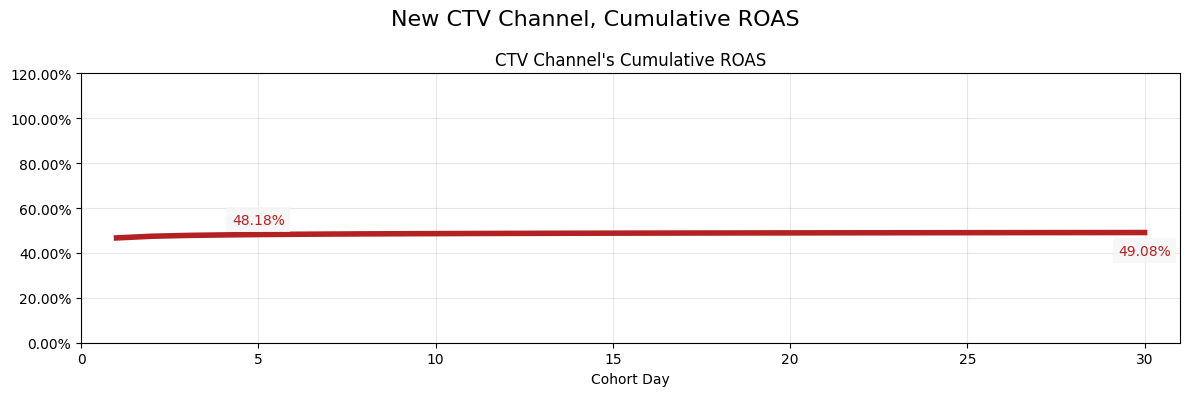

In [4]:
'''
what if ROAS is flat to up?
could be a good thing...but that assumes ROAS curve for new channel has same shape as blended
- show new cohort with roughly same blended ROAS
'''

## define a new funtion -- for a CTV ad channel
def CTV_cumulative_roas( scale, baseline ):
    ## function that simulates a CTV channel's cumulative ROAS trajectory
    ## saturated power function
    return lambda x: ( .50 * ( x ** scale / ( x ** scale + baseline ) ) )

channel_6 = create_channel( CTV_cumulative_roas, scale=None, baseline=None )

channels.append( channel_6 )

## graph channel 6's cumulative ROAS
channel_6_roas = [ channel_6[ 'cumulative_ROAS' ]( x ) * 100 for x in range( 1, periods+1 ) ]

fig, ax = plt.subplots( figsize=( 12, 4 ) )

graph_ax( ax, channel_6_roas, periods, "CTV Channel's Cumulative ROAS", color=colors[ -1 ] )

plt.xlabel( "Cohort Day" )

plt.suptitle( "New CTV Channel, Cumulative ROAS", fontsize=16 )
plt.tight_layout()
plt.show()

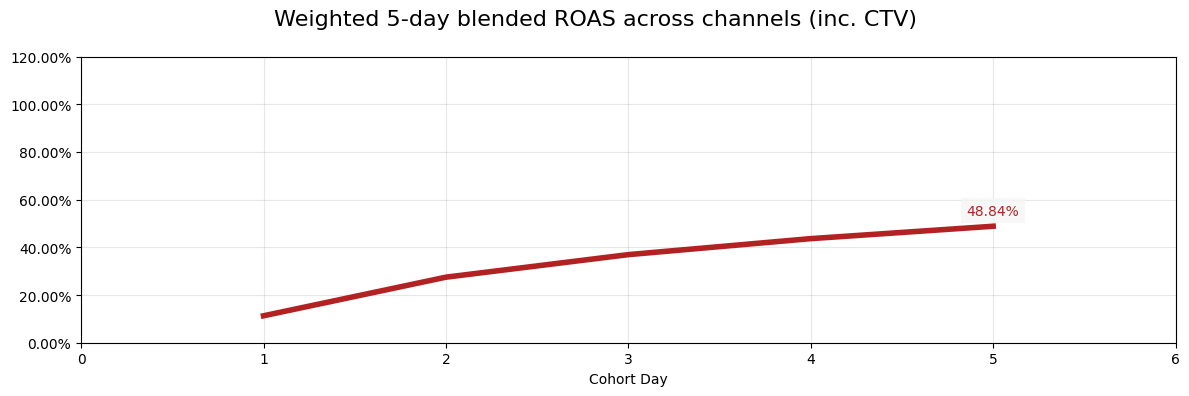

In [7]:
## total blended DR ROAS
total_ad_spend = get_total_ad_spend( channels )
new_blended_roas = get_blended_ROAS( channels, periods )

fig, ax = plt.subplots( figsize=( 12, 4 ) )

graph_ax( ax, new_blended_roas[ :5 ], 5, "", color=colors[ -1 ] )

plt.xlabel( "Cohort Day" )

plt.suptitle( "Weighted 5-day blended ROAS across channels (inc. CTV)", fontsize=16 )
plt.tight_layout()
plt.show()

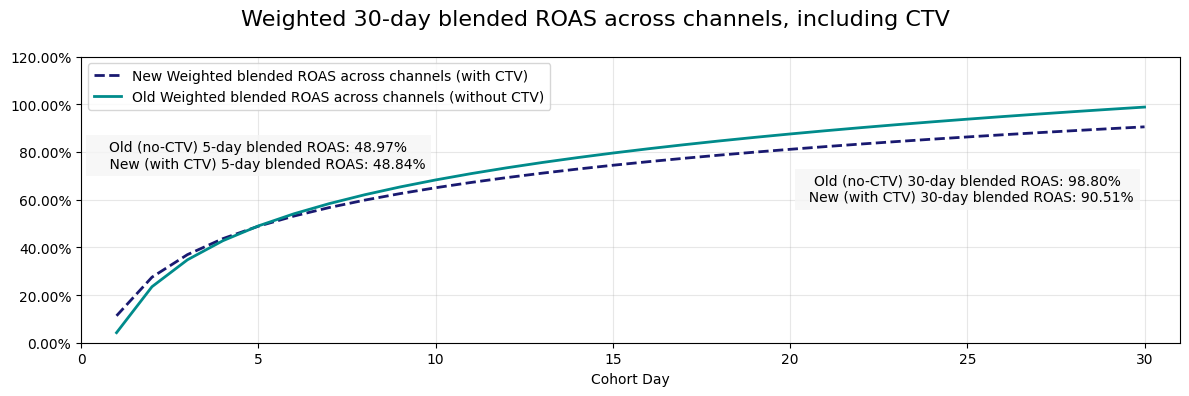

In [6]:
## plot new vs old blended ROAS

fig, ax = plt.subplots( figsize=( 12, 4 ) )

x_vals = list( range( 1, periods+1, 1 ) )

## old blended ROAS
ax.plot(
    x_vals,
    new_blended_roas,
    color='midnightblue',
    linestyle='dashed',
    label='New Weighted blended ROAS across channels (with CTV)',
    linewidth=2
)

ax.plot(
    x_vals,
    blended_roas,
    color='darkcyan',
    linestyle='solid',
    label='Old Weighted blended ROAS across channels (without CTV)',
    linewidth=2
)
    
plt.xlabel( "Cohort Day" )

ax.grid( alpha=0.3 )
ax.set_facecolor( "white" )
fig.patch.set_facecolor( "white" )
ax.yaxis.set_major_formatter( mtick.PercentFormatter( decimals=2 ) )
ax.set_xlim( 0, periods + 1 )
ax.set_ylim( 0, 120 )

## annotations
ax.annotate( 
    f"Old (no-CTV) 5-day blended ROAS: {blended_roas[ 4 ]:.2f}%\n    New (with CTV) 5-day blended ROAS: {new_blended_roas[ 4 ]:.2f}%", 
    xy=( 5, blended_roas[ 4 ] * 1.5 ), 
    xytext=( 5, blended_roas[ 4 ] * 1.5 ),
    fontsize=10,
    ha='center',
    color='black',
    bbox=dict( facecolor='whitesmoke', edgecolor='none', alpha=0.8 )
)

ax.annotate( 
    f"Old (no-CTV) 30-day blended ROAS: {blended_roas[ -1 ]:.2f}%\n  New (with CTV) 30-day blended ROAS: {new_blended_roas[ -1 ]:.2f}%", 
    xy=( 25, blended_roas[ -1 ] * .6 ), 
    xytext=( 25, blended_roas[ -1 ] * .6 ),
    fontsize=10,
    ha='center',
    color='black',
    bbox=dict( facecolor='whitesmoke', edgecolor='none', alpha=0.8 )
)

ax.legend()

plt.suptitle( "Weighted 30-day blended ROAS across channels, including CTV", fontsize=16 )
plt.tight_layout()
plt.show()